In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline

In [3]:
import numpy as np
import pandas as pd
import scipy.stats as st

import matplotlib.pyplot as plt
import seaborn as sns
from bokeh.plotting import output_notebook, show

from scipy import stats

import suppression as s
import utils
import two_stage_model as model
import plotting as p

In [4]:
gaba_fn = 'gaba_data.txt'
supp_fn = 'supp_data_individual_20170427.txt'

In [5]:
sdf = utils.load_psychophys(supp_fn)
gdf = utils.load_gaba(gaba_fn)

## Analyze tasks separately (before subsetting to include common subjects)##

In [6]:
pp_subjs = np.unique(sdf.Subject)
gaba_subjs = np.unique(gdf.subjName)
print(pp_subjs, len(pp_subjs))
print(gaba_subjs, len(gaba_subjs))

['ah' 'ai' 'am' 'ap' 'bi' 'bo' 'cl' 'cr' 'ct' 'dl' 'ds' 'eg' 'ei' 'em' 'es'
 'gd' 'gm' 'gw' 'jd' 'jv' 'ke' 'kw' 'li' 'ls' 'mg' 'mk' 'ms' 'mv' 'nl' 'nn'
 'rn' 'sd' 'se' 'tj' 'tm' 'tt' 'yl'] 37
['ac' 'ai' 'am' 'as' 'bi' 'ch' 'cr' 'cs' 'ct' 'dl' 'ei' 'em' 'es' 'gd' 'gm'
 'jd' 'jm' 'jv' 'ks' 'kw' 'li' 'ls' 'mg' 'mk' 'ms' 'nl' 'ps' 'rn' 'sd' 'tt'
 'yl'] 31


### GABA plot, n=31 (all)

### GABA t-test, CON v AMB

In [7]:
pop_group = gdf.groupby("Population")
pop_group.describe()

GABA                                                           
           count      mean       std    min     25%     50%      75%    max
Population                                                                 
Amblyope    16.0  0.202312  0.013385  0.179  0.1925  0.2025  0.21125  0.227
Control     15.0  0.206333  0.016482  0.173  0.1925  0.2110  0.21650  0.228

In [8]:
gaba_per_group = [col for col_name, col in pop_group['GABA']]
(tstat, pval) = st.ttest_ind(*gaba_per_group)
print(tstat, pval)

-0.747810754413 0.460595837907


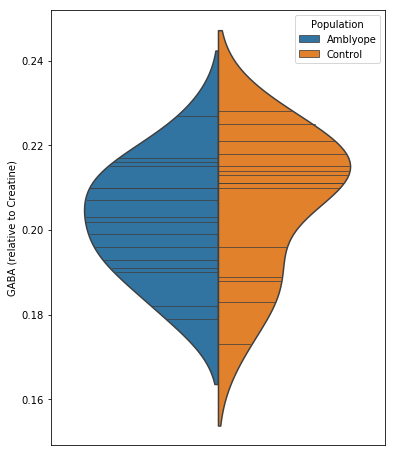

In [9]:
with s.PdfPages('plots/redo-201805/gaba_diffs_n31.pdf') as pdf:
    fig = plt.figure(figsize=(6,8))  # create a figure object
    ax = fig.add_subplot(1, 1, 1)
    ax = sns.violinplot(y='GABA',x='Presentation',hue='Population',data=gdf,split=True,inner='stick',ax=ax)
    ax.xaxis.set_visible(False)
    ax.set_ylabel("GABA (relative to Creatine)")
    plt.show(ax.figure)
    pdf.savefig(ax.figure)
    plt.close(ax.figure)
    plt.close('all')

## Select one psychophysical task's data ##

In [10]:
task = 'SS'
sdf = sdf[sdf['Task']==task]

### Begin grouping data into conditions to model Subject's ThreshElev as a function of logRelContrast #

In [11]:
pp_gvars = ['Task','Orientation','Presentation','Population','Subject','Eye','Trace'] # One condition
pp_collapse_vars = ['Presentation'] # the different levels of these factors will all be fit at once
pp_gvars_base = pp_gvars + ['BaselineThresh']

In [12]:
# create groups based on these grouping variables
groups = sdf.groupby(pp_gvars)
print(len(groups))
for gv, g in groups:
    print(gv)

256
('SS', 'Cross', 'nDicho', 'Amblyope', 'ah', 'De', 'Amblyope-De')
('SS', 'Cross', 'nDicho', 'Amblyope', 'ah', 'Nde', 'Amblyope-Nde')
('SS', 'Cross', 'nDicho', 'Amblyope', 'am', 'De', 'Amblyope-De')
('SS', 'Cross', 'nDicho', 'Amblyope', 'am', 'Nde', 'Amblyope-Nde')
('SS', 'Cross', 'nDicho', 'Amblyope', 'bi', 'De', 'Amblyope-De')
('SS', 'Cross', 'nDicho', 'Amblyope', 'bi', 'Nde', 'Amblyope-Nde')
('SS', 'Cross', 'nDicho', 'Amblyope', 'cl', 'De', 'Amblyope-De')
('SS', 'Cross', 'nDicho', 'Amblyope', 'cl', 'Nde', 'Amblyope-Nde')
('SS', 'Cross', 'nDicho', 'Amblyope', 'eg', 'De', 'Amblyope-De')
('SS', 'Cross', 'nDicho', 'Amblyope', 'eg', 'Nde', 'Amblyope-Nde')
('SS', 'Cross', 'nDicho', 'Amblyope', 'em', 'De', 'Amblyope-De')
('SS', 'Cross', 'nDicho', 'Amblyope', 'em', 'Nde', 'Amblyope-Nde')
('SS', 'Cross', 'nDicho', 'Amblyope', 'gd', 'De', 'Amblyope-De')
('SS', 'Cross', 'nDicho', 'Amblyope', 'gd', 'Nde', 'Amblyope-Nde')
('SS', 'Cross', 'nDicho', 'Amblyope', 'jv', 'De', 'Amblyope-De')
('SS', 

### Do t-tests between corresponding points (to find bin where the groups are most different)

In [13]:
tt_df = sdf

In [14]:
tt_df.head()

,Subject,Task,Presentation,Orientation,Eye,Population,MaskContrast,ThreshElev,ThreshElev_SE,RelMaskContrast,Trace,BaselineThresh,BinCenterRelMaskContrast,BinNumber,logThreshElev
0,ai,SS,nMono,Iso,Nde,Control,10.0,0.615,0.009,1.449,Control-Nde,6.900,1.552,2,-0.211125
1,ai,SS,nMono,Iso,Nde,Control,30.0,0.671,0.010,4.348,Control-Nde,6.900,3.944,4,-0.173277
2,ai,SS,nMono,Iso,Nde,Control,62.0,1.658,0.007,8.986,Control-Nde,6.900,11.345,6,0.219585
3,ap,SS,nMono,Iso,Nde,Control,5.0,1.277,0.007,0.961,Control-Nde,5.205,0.960,1,0.106191
4,ap,SS,nMono,Iso,Nde,Control,10.0,1.096,0.004,1.921,Control-Nde,5.205,1.552,2,0.039811


In [15]:
gvars_ttest = ['Task','Orientation','Presentation','Population']
gvars_pair = gvars_ttest + ['BinNumber']

tt_grouped = tt_df.groupby(gvars_ttest)
print(len(tt_grouped))

for gv, g in tt_grouped:
    print(gv)

8
('SS', 'Cross', 'nDicho', 'Amblyope')
('SS', 'Cross', 'nDicho', 'Control')
('SS', 'Cross', 'nMono', 'Amblyope')
('SS', 'Cross', 'nMono', 'Control')
('SS', 'Iso', 'nDicho', 'Amblyope')
('SS', 'Iso', 'nDicho', 'Control')
('SS', 'Iso', 'nMono', 'Amblyope')
('SS', 'Iso', 'nMono', 'Control')


In [16]:
def tt(ttg_allbin):
    '''Accepts data grouped by Task, Orientation, Presentation, Population, then analyzes each bin within this.'''
    g_bin = ttg_allbin.groupby(gvars_pair).apply(tt_onebin).reset_index()
    minp_bin = g_bin.BinNumber.iat[g_bin.pvalue.idxmin()]
    print('Bin ', minp_bin, 'has lowest p-value.\n')
    return pd.Series(minp_bin, ['BinNumberToPred'])

def tt_onebin(ttg):
    '''Accepts data grouped by Task, Orientation, Presentation, Population, BinNumber, and does a t-test on the values in the bin.'''
    nde = ttg[ttg['Eye']=='Nde']['ThreshElev'].values
    de = ttg[ttg['Eye']=='De']['ThreshElev'].values
    print(ttg.name, ttg.BinCenterRelMaskContrast.iat[0], nde, de, sep='\n')
    if (len(nde) >0 and len(de) >0):
        tt_res = st.ttest_ind(nde, de)
        if tt_res:
            return pd.Series(tt_res[1], ['pvalue'])
    else:
        print('A group with no obs, skipping')

tt_results = tt_grouped.apply(tt).reset_index()

('SS', 'Cross', 'nDicho', 'Amblyope', 1)
0.792
[ 1.921  1.434  0.805  1.043]
[ 0.947  1.026  0.807]
('SS', 'Cross', 'nDicho', 'Amblyope', 1)
0.792
[ 1.921  1.434  0.805  1.043]
[ 0.947  1.026  0.807]
('SS', 'Cross', 'nDicho', 'Amblyope', 2)
1.432
[ 1.23   1.056  1.057  2.058  1.112  1.755  0.888  1.296  1.229  1.076]
[ 0.859  0.542  0.98   0.642]
('SS', 'Cross', 'nDicho', 'Amblyope', 3)
2.604
[ 1.629  1.378  2.68   0.989  3.318  1.007  1.459  0.68   1.555  1.14 ]
[ 0.505  1.014  1.093  0.759  0.964  0.867  1.099  1.177  0.718]
('SS', 'Cross', 'nDicho', 'Amblyope', 4)
4.526
[ 1.783  1.275  1.585  4.893  1.056  1.195  1.369  1.222  1.337]
[ 0.689  0.553  0.935  0.99   1.22   0.617  1.125  1.17   0.76   0.591
  0.685]
('SS', 'Cross', 'nDicho', 'Amblyope', 5)
7.257
[ 1.81   1.677  2.306  1.377  1.49   2.387  0.82   1.708]
[ 0.792  0.416  0.918  0.855  0.956  1.     1.05   1.022  1.241]
('SS', 'Cross', 'nDicho', 'Amblyope', 6)
10.949
[ 1.79   1.331  1.419  1.277  4.002  1.711]
[ 0.898  0.48

[ 6.08   1.998  3.277  2.71 ]
Bin  6 has lowest p-value.

('SS', 'Iso', 'nMono', 'Amblyope', 1)
0.616
[ 0.983  0.556  0.669]
[ 0.965  0.538  0.834  0.619]
('SS', 'Iso', 'nMono', 'Amblyope', 1)
0.616
[ 0.983  0.556  0.669]
[ 0.965  0.538  0.834  0.619]
('SS', 'Iso', 'nMono', 'Amblyope', 2)
0.878
[ 0.838  1.033  1.052  0.823]
[ 0.624  0.464  0.837  0.818  0.717  0.628  0.884  1.155  0.997  0.686]
('SS', 'Iso', 'nMono', 'Amblyope', 3)
1.496
[ 0.793  1.237  1.019  0.812  1.022  0.702  0.58   1.155  0.756]
[ 0.494  0.393  1.009  0.649  0.736  0.856  0.96   0.841  1.14   0.515]
('SS', 'Iso', 'nMono', 'Amblyope', 4)
2.5
[ 1.316  0.736  1.195  1.247  0.971  1.159  1.003  0.61   1.15   1.32
  2.083]
[ 1.     0.473  1.623  1.438  1.323  1.738  1.233  1.414  1.028]
('SS', 'Iso', 'nMono', 'Amblyope', 5)
4.33
[ 1.301  0.904  1.816  2.147  1.533  1.58   1.212  0.905  1.315]
[ 1.576  0.831  2.35   1.632  2.298  1.778  1.269  1.469]
('SS', 'Iso', 'nMono', 'Amblyope', 6)
6.995
[ 1.919  1.243  1.495  1.

In [17]:
tt_results

,Task,Orientation,Presentation,Population,BinNumberToPred
0,SS,Cross,nDicho,Amblyope,5
1,SS,Cross,nDicho,Control,1
2,SS,Cross,nMono,Amblyope,3
3,SS,Cross,nMono,Control,1
4,SS,Iso,nDicho,Amblyope,4
5,SS,Iso,nDicho,Control,6
6,SS,Iso,nMono,Amblyope,2
7,SS,Iso,nMono,Control,2


In [18]:
sdf = pd.merge(sdf, tt_results, on=gvars_ttest)

In [19]:
sdf.head()

,Subject,Task,Presentation,Orientation,Eye,Population,MaskContrast,ThreshElev,ThreshElev_SE,RelMaskContrast,Trace,BaselineThresh,BinCenterRelMaskContrast,BinNumber,logThreshElev,BinNumberToPred
0,ai,SS,nMono,Iso,Nde,Control,10.0,0.615,0.009,1.449,Control-Nde,6.900,1.552,2,-0.211125,2
1,ai,SS,nMono,Iso,Nde,Control,30.0,0.671,0.010,4.348,Control-Nde,6.900,3.944,4,-0.173277,2
2,ai,SS,nMono,Iso,Nde,Control,62.0,1.658,0.007,8.986,Control-Nde,6.900,11.345,6,0.219585,2
3,ap,SS,nMono,Iso,Nde,Control,5.0,1.277,0.007,0.961,Control-Nde,5.205,0.960,1,0.106191,2
4,ap,SS,nMono,Iso,Nde,Control,10.0,1.096,0.004,1.921,Control-Nde,5.205,1.552,2,0.039811,2


In [20]:
# make sure all conditions have the same bin number to predict within them
condition_groups = sdf.groupby(gvars_ttest + ['Eye'])
assert(np.all(condition_groups.apply(
        lambda g: np.all(g.BinNumberToPred==g.BinNumberToPred.iat[0])
    ).reset_index()))

In [21]:
gvars_ttest

['Task', 'Orientation', 'Presentation', 'Population']

In [22]:
# add col with numeric value at which we want model to be evaluated
# this is determined per condition so reuse var
def add_pred_col(g):
    assert(np.all(g.BinNumberToPred==g.BinNumberToPred.iat[0]))
    RelMCToPredGroup = g[g.BinNumber==g.BinNumberToPred.iat[0]]
    assert(np.all(RelMCToPredGroup.BinCenterRelMaskContrast==RelMCToPredGroup.BinCenterRelMaskContrast.iat[0]))
    RelMCToPred = RelMCToPredGroup.BinCenterRelMaskContrast.iat[0]
    print(RelMCToPred, len(g))
    g['RelMCToPred'] = RelMCToPred
    return g
    
df_to_model = condition_groups.apply(add_pred_col)

4.33 51
4.33 51
7.257 49
0.879 54
0.991 84
2.637 53
1.496 52
0.971 54
0.925 88
2.5 51
4.526 49
11.877 54
11.35 85
1.463 53
0.878 54
1.599 54
1.552 85


In [23]:
df_to_model.head()

,Subject,Task,Presentation,Orientation,Eye,Population,MaskContrast,ThreshElev,ThreshElev_SE,RelMaskContrast,Trace,BaselineThresh,BinCenterRelMaskContrast,BinNumber,logThreshElev,BinNumberToPred,RelMCToPred
0,ai,SS,nMono,Iso,Nde,Control,10.0,0.615,0.009,1.449,Control-Nde,6.900,1.552,2,-0.211125,2,1.552
1,ai,SS,nMono,Iso,Nde,Control,30.0,0.671,0.010,4.348,Control-Nde,6.900,3.944,4,-0.173277,2,1.552
2,ai,SS,nMono,Iso,Nde,Control,62.0,1.658,0.007,8.986,Control-Nde,6.900,11.345,6,0.219585,2,1.552
3,ap,SS,nMono,Iso,Nde,Control,5.0,1.277,0.007,0.961,Control-Nde,5.205,0.960,1,0.106191,2,1.552
4,ap,SS,nMono,Iso,Nde,Control,10.0,1.096,0.004,1.921,Control-Nde,5.205,1.552,2,0.039811,2,1.552


In [24]:
n_pp_subs_thistask = len(np.unique(df_to_model.Subject))
print(n_pp_subs_thistask, len(np.unique((df_to_model[df_to_model['Population']=='Amblyope'])['Subject'])))

35 13


### Two-stage Model (defined in two_Stage_model.py)

In [25]:
twostage_params = model.two_stage_parameters()

### Model all data points, incl. facilitation ###

In [26]:
modeling_gvars = [x for x in pp_gvars_base if x not in pp_collapse_vars]
print(modeling_gvars)

['Task', 'Orientation', 'Population', 'Subject', 'Eye', 'Trace', 'BaselineThresh']


In [27]:
groups = df_to_model.groupby(modeling_gvars)

In [28]:
# two-stage model
preds_wfac = groups.apply(utils.model_threshold, model.two_stage_response_err, model.two_stage_thresh, twostage_params,
                     ret='preds')

('SS', 'Cross', 'Amblyope', 'ah', 'De', 'Amblyope-De', 7.5899999999999999)
Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
S           1     -inf      inf        0    False     None     None
Z      0.0085     -inf      inf        0    False     None     None
a           0     -inf      inf        0    False     None     None
k         0.2     -inf      inf        0    False     None     None
m         1.3     -inf      inf        0    False     None     None
p           8     -inf      inf        0    False     None     None
q         6.5     -inf      inf        0    False     None     None
w_d  2.092e-09        0      inf        0     True     None     None
w_m  2.931e-14        0      inf        0     True     None     None
('SS', 'Cross', 'Amblyope', 'ah', 'De', 'Amblyope-De', 7.5899999999999999)
Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
S           1     -inf      inf        0    False     None     None
Z      0.0085     -inf    

q         6.5     -inf      inf        0    False     None     None
w_d  8.532e-10        0      inf        0     True     None     None
w_m   0.06689        0      inf        0     True     None     None
('SS', 'Cross', 'Amblyope', 'em', 'Nde', 'Amblyope-Nde', 6.0139999999999993)
Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
S           1     -inf      inf        0    False     None     None
Z      0.0085     -inf      inf        0    False     None     None
a           0     -inf      inf        0    False     None     None
k         0.2     -inf      inf        0    False     None     None
m         1.3     -inf      inf        0    False     None     None
p           8     -inf      inf        0    False     None     None
q         6.5     -inf      inf        0    False     None     None
w_d     1.508        0      inf   0.3067     True     None     None
w_m     0.054        0      inf   0.0255     True     None     None
('SS', 'Cross', 'Amblyope', 'gd', '

Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
S           1     -inf      inf        0    False     None     None
Z      0.0085     -inf      inf        0    False     None     None
a           0     -inf      inf        0    False     None     None
k         0.2     -inf      inf        0    False     None     None
m         1.3     -inf      inf        0    False     None     None
p           8     -inf      inf        0    False     None     None
q         6.5     -inf      inf        0    False     None     None
w_d    0.2739        0      inf   0.0898     True     None     None
w_m    0.0298        0      inf  0.08463     True     None     None
('SS', 'Cross', 'Amblyope', 'sd', 'De', 'Amblyope-De', 6.2620000000000005)
Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
S           1     -inf      inf        0    False     None     None
Z      0.0085     -inf      inf        0    False     None     None
a           0     -inf      inf    

('SS', 'Cross', 'Control', 'ei', 'De', 'Control-De', 6.4579999999999993)
Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
S           1     -inf      inf        0    False     None     None
Z      0.0085     -inf      inf        0    False     None     None
a           0     -inf      inf        0    False     None     None
k         0.2     -inf      inf        0    False     None     None
m         1.3     -inf      inf        0    False     None     None
p           8     -inf      inf        0    False     None     None
q         6.5     -inf      inf        0    False     None     None
w_d    0.1067        0      inf        0     True     None     None
w_m     104.3        0      inf        0     True     None     None
('SS', 'Cross', 'Control', 'ei', 'Nde', 'Control-Nde', 4.9850000000000003)
Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
S           1     -inf      inf        0    False     None     None
Z      0.0085     -inf      in

Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
S           1     -inf      inf        0    False     None     None
Z      0.0085     -inf      inf        0    False     None     None
a           0     -inf      inf        0    False     None     None
k         0.2     -inf      inf        0    False     None     None
m         1.3     -inf      inf        0    False     None     None
p           8     -inf      inf        0    False     None     None
q         6.5     -inf      inf        0    False     None     None
w_d      13.1        0      inf        0     True     None     None
w_m   0.04703        0      inf        0     True     None     None
('SS', 'Cross', 'Control', 'ls', 'De', 'Control-De', 9.9870000000000001)
Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
S           1     -inf      inf        0    False     None     None
Z      0.0085     -inf      inf        0    False     None     None
a           0     -inf      inf      

w_m     20.06        0      inf        0     True     None     None
('SS', 'Cross', 'Control', 'tj', 'Nde', 'Control-Nde', 5.0060000000000002)
Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
S           1     -inf      inf        0    False     None     None
Z      0.0085     -inf      inf        0    False     None     None
a           0     -inf      inf        0    False     None     None
k         0.2     -inf      inf        0    False     None     None
m         1.3     -inf      inf        0    False     None     None
p           8     -inf      inf        0    False     None     None
q         6.5     -inf      inf        0    False     None     None
w_d  2.718e-09        0      inf        0     True     None     None
w_m     26.29        0      inf        0     True     None     None
('SS', 'Cross', 'Control', 'tm', 'De', 'Control-De', 6.8920000000000003)
Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
S           1     -inf      i

Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
S           1     -inf      inf        0    False     None     None
Z      0.0085     -inf      inf        0    False     None     None
a           0     -inf      inf        0    False     None     None
k         0.2     -inf      inf        0    False     None     None
m         1.3     -inf      inf        0    False     None     None
p           8     -inf      inf        0    False     None     None
q         6.5     -inf      inf        0    False     None     None
w_d    0.1495        0      inf        0     True     None     None
w_m     25.48        0      inf        0     True     None     None
('SS', 'Iso', 'Amblyope', 'eg', 'Nde', 'Amblyope-Nde', 6.7870000000000008)
Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
S           1     -inf      inf        0    False     None     None
Z      0.0085     -inf      inf        0    False     None     None
a           0     -inf      inf    

S           1     -inf      inf        0    False     None     None
Z      0.0085     -inf      inf        0    False     None     None
a           0     -inf      inf        0    False     None     None
k         0.2     -inf      inf        0    False     None     None
m         1.3     -inf      inf        0    False     None     None
p           8     -inf      inf        0    False     None     None
q         6.5     -inf      inf        0    False     None     None
w_d     31.36        0      inf        0     True     None     None
w_m   0.05467        0      inf        0     True     None     None
('SS', 'Iso', 'Amblyope', 'rn', 'Nde', 'Amblyope-Nde', 8.907)
Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
S           1     -inf      inf        0    False     None     None
Z      0.0085     -inf      inf        0    False     None     None
a           0     -inf      inf        0    False     None     None
k         0.2     -inf      inf        0    False  

Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
S           1     -inf      inf        0    False     None     None
Z      0.0085     -inf      inf        0    False     None     None
a           0     -inf      inf        0    False     None     None
k         0.2     -inf      inf        0    False     None     None
m         1.3     -inf      inf        0    False     None     None
p           8     -inf      inf        0    False     None     None
q         6.5     -inf      inf        0    False     None     None
w_d    0.4601        0      inf        0     True     None     None
w_m     65.42        0      inf        0     True     None     None
('SS', 'Iso', 'Control', 'ei', 'Nde', 'Control-Nde', 4.9850000000000003)
Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
S           1     -inf      inf        0    False     None     None
Z      0.0085     -inf      inf        0    False     None     None
a           0     -inf      inf      

m         1.3     -inf      inf        0    False     None     None
p           8     -inf      inf        0    False     None     None
q         6.5     -inf      inf        0    False     None     None
w_d     13.67        0      inf        0     True     None     None
w_m    0.3209        0      inf        0     True     None     None
('SS', 'Iso', 'Control', 'ls', 'De', 'Control-De', 9.9870000000000001)
Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
S           1     -inf      inf        0    False     None     None
Z      0.0085     -inf      inf        0    False     None     None
a           0     -inf      inf        0    False     None     None
k         0.2     -inf      inf        0    False     None     None
m         1.3     -inf      inf        0    False     None     None
p           8     -inf      inf        0    False     None     None
q         6.5     -inf      inf        0    False     None     None
w_d    0.3218        0      inf        0  

w_m    0.3145        0      inf  0.08992     True     None     None
('SS', 'Iso', 'Control', 'yl', 'De', 'Control-De', 5.2720000000000002)
Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
S           1     -inf      inf        0    False     None     None
Z      0.0085     -inf      inf        0    False     None     None
a           0     -inf      inf        0    False     None     None
k         0.2     -inf      inf        0    False     None     None
m         1.3     -inf      inf        0    False     None     None
p           8     -inf      inf        0    False     None     None
q         6.5     -inf      inf        0    False     None     None
w_d     0.152        0      inf        0     True     None     None
w_m     17.57        0      inf        0     True     None     None
('SS', 'Iso', 'Control', 'yl', 'Nde', 'Control-Nde', 4.7380000000000004)
Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
S           1     -inf      inf   

In [29]:
model.two_stage_response_err(twostage_params, [0], [0], [0], [0])-twostage_params['k']

array([ 0.])

## Descriptive statistics

In [30]:
preds_wfac.groupby(["Orientation", "Presentation", "Population", "Eye"])["ThreshPred"].describe()

count      mean       std       min  \
Orientation Presentation Population Eye                                        
Cross       nDicho       Amblyope   De    51.0  1.160896  0.684381  0.316000   
                                    Nde   49.0  1.157435  0.259416  0.815000   
                         Control    De    54.0  0.971601  0.305517  0.447000   
                                    Nde   84.0  1.101608  0.281061  0.480000   
            nMono        Amblyope   De    53.0  1.109297  0.265881  0.782000   
                                    Nde   52.0  1.634932  0.722174  0.805000   
                         Control    De    54.0  1.301695  0.415212  0.646000   
                                    Nde   88.0  1.556916  0.815689  0.745000   
Iso         nDicho       Amblyope   De    51.0  1.552422  0.849913  0.494000   
                                    Nde   49.0  1.804282  0.869191  0.736000   
                         Control    De    54.0  1.698161  1.033637  0.574000   
                                    Nde   85.0  1.856519  1.101140  0.531000   
            nMono        Amblyope   De    53.0  1.072085  0.323855  0.429000   
                                    Nde   54.0  2.470616  1.212120  1.025278   
                         Control    De    54.0  2.034870  0.902438  1.079672   
                                    Nde   85.0  2.398986  1.223189  0.782000   

                                              25%       50%       75%  \
Orientation Presentation Population Eye                                 
Cross       nDicho       Amblyope   De   0.878000  1.031912  1.287154   
                                    Nde  1.000256  1.055657  1.232000   
                         Control    De   0.736500  0.916500  1.137667   
                                    Nde  1.000256  1.077224  1.237017   
            nMono        Amblyope   De   1.000256  1.000256  1.112343   
                                    Nde  1.141434  1.394061  1.763869   
                         Control    De   1.050282  1.173621  1.438050   
                                    Nde  1.074455  1.271437  1.766074   
Iso         nDicho       Amblyope   De   1.000256  1.279781  2.057646   
                                    Nde  1.238485  1.495000  2.112754   
                         Control    De   1.038500  1.388240  1.965111   
                                    Nde  1.166000  1.592000  2.226636   
            nMono        Amblyope   De   1.000256  1.068553  1.223481   
                                    Nde  1.509640  2.101626  3.074413   
                         Control    De   1.354095  1.763249  2.385047   
                                    Nde  1.493040  2.008271  2.926670   

                                              max  
Orientation Presentation Population Eye            
Cross       nDicho       Amblyope   De   5.190783  
                                    Nde  2.176324  
                         Control    De   1.825000  
                                    Nde  2.034000  
            nMono        Amblyope   De   2.575329  
                                    Nde  4.559742  
                         Control    De   2.932000  
                                    Nde  6.109000  
Iso         nDicho       Amblyope   De   4.051880  
                                    Nde  4.760688  
                         Control    De   6.119491  
                                    Nde  6.268867  
            nMono        Amblyope   De   2.115385  
                                    Nde  5.928282  
                         Control    De   6.057405  
                                    Nde  6.962122

In [31]:
s.group_facet_plots(preds_wfac, s.fit_plot, 'plots/redo-201805/{}_predsv3_combinedplots_n{}.pdf'.format(task, n_pp_subs_thistask),
                  ['Task','Orientation','Presentation'], #each combo of this gets its own page
                  row='Population',col='Eye',# facet rows and columns
                  x="RelMaskContrast", y="ThreshElev", # x, y
                  hue="Subject",yerr='ThreshElev_SE',fmt_obs='o',fmt_pred='.--',Ycol="ThreshPred") 

Plotting SS.Cross.nDicho
Plotting SS.Cross.nMono
Plotting SS.Iso.nDicho
Plotting SS.Iso.nMono
Plots saved at plots/redo-201805/SS_predsv3_combinedplots_n35.pdf


### Model the data again, but this time return parameters, not predictions ###

In [32]:
modeling_gvars_base = [x for x in pp_gvars_base if x not in pp_collapse_vars]
print(pp_gvars_base, modeling_gvars_base)
groups_with_baseline = df_to_model.groupby(modeling_gvars_base)

['Task', 'Orientation', 'Presentation', 'Population', 'Subject', 'Eye', 'Trace', 'BaselineThresh'] ['Task', 'Orientation', 'Population', 'Subject', 'Eye', 'Trace', 'BaselineThresh']


In [33]:
# two-stage model
pfit = groups_with_baseline.apply(utils.model_threshold, model.two_stage_response_err, model.two_stage_thresh,
                                  twostage_params, ret='weights').reset_index()

('SS', 'Cross', 'Amblyope', 'ah', 'De', 'Amblyope-De', 7.5899999999999999)
Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
S           1     -inf      inf        0    False     None     None
Z      0.0085     -inf      inf        0    False     None     None
a           0     -inf      inf        0    False     None     None
k         0.2     -inf      inf        0    False     None     None
m         1.3     -inf      inf        0    False     None     None
p           8     -inf      inf        0    False     None     None
q         6.5     -inf      inf        0    False     None     None
w_d  2.092e-09        0      inf        0     True     None     None
w_m  2.931e-14        0      inf        0     True     None     None
('SS', 'Cross', 'Amblyope', 'ah', 'De', 'Amblyope-De', 7.5899999999999999)
Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
S           1     -inf      inf        0    False     None     None
Z      0.0085     -inf    

q         6.5     -inf      inf        0    False     None     None
w_d  8.532e-10        0      inf        0     True     None     None
w_m   0.06689        0      inf        0     True     None     None
('SS', 'Cross', 'Amblyope', 'em', 'Nde', 'Amblyope-Nde', 6.0139999999999993)
Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
S           1     -inf      inf        0    False     None     None
Z      0.0085     -inf      inf        0    False     None     None
a           0     -inf      inf        0    False     None     None
k         0.2     -inf      inf        0    False     None     None
m         1.3     -inf      inf        0    False     None     None
p           8     -inf      inf        0    False     None     None
q         6.5     -inf      inf        0    False     None     None
w_d     1.508        0      inf   0.3067     True     None     None
w_m     0.054        0      inf   0.0255     True     None     None
('SS', 'Cross', 'Amblyope', 'gd', '

Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
S           1     -inf      inf        0    False     None     None
Z      0.0085     -inf      inf        0    False     None     None
a           0     -inf      inf        0    False     None     None
k         0.2     -inf      inf        0    False     None     None
m         1.3     -inf      inf        0    False     None     None
p           8     -inf      inf        0    False     None     None
q         6.5     -inf      inf        0    False     None     None
w_d  1.374e-09        0      inf  0.09445     True     None     None
w_m  9.664e-09        0      inf   0.1121     True     None     None
('SS', 'Cross', 'Amblyope', 'rn', 'Nde', 'Amblyope-Nde', 8.907)
Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
S           1     -inf      inf        0    False     None     None
Z      0.0085     -inf      inf        0    False     None     None
a           0     -inf      inf        0    

Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
S           1     -inf      inf        0    False     None     None
Z      0.0085     -inf      inf        0    False     None     None
a           0     -inf      inf        0    False     None     None
k         0.2     -inf      inf        0    False     None     None
m         1.3     -inf      inf        0    False     None     None
p           8     -inf      inf        0    False     None     None
q         6.5     -inf      inf        0    False     None     None
w_d    0.5325        0      inf   0.1451     True     None     None
w_m    0.0707        0      inf   0.0469     True     None     None
('SS', 'Cross', 'Control', 'ei', 'De', 'Control-De', 6.4579999999999993)
Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
S           1     -inf      inf        0    False     None     None
Z      0.0085     -inf      inf        0    False     None     None
a           0     -inf      inf      

Z      0.0085     -inf      inf        0    False     None     None
a           0     -inf      inf        0    False     None     None
k         0.2     -inf      inf        0    False     None     None
m         1.3     -inf      inf        0    False     None     None
p           8     -inf      inf        0    False     None     None
q         6.5     -inf      inf        0    False     None     None
w_d      13.1        0      inf        0     True     None     None
w_m   0.04703        0      inf        0     True     None     None
('SS', 'Cross', 'Control', 'ls', 'De', 'Control-De', 9.9870000000000001)
Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
S           1     -inf      inf        0    False     None     None
Z      0.0085     -inf      inf        0    False     None     None
a           0     -inf      inf        0    False     None     None
k         0.2     -inf      inf        0    False     None     None
m         1.3     -inf      inf        0

Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
S           1     -inf      inf        0    False     None     None
Z      0.0085     -inf      inf        0    False     None     None
a           0     -inf      inf        0    False     None     None
k         0.2     -inf      inf        0    False     None     None
m         1.3     -inf      inf        0    False     None     None
p           8     -inf      inf        0    False     None     None
q         6.5     -inf      inf        0    False     None     None
w_d    0.2129        0      inf  0.05978     True     None     None
w_m   0.03167        0      inf  0.02966     True     None     None
('SS', 'Cross', 'Control', 'tm', 'Nde', 'Control-Nde', 6.0089999999999995)
Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
S           1     -inf      inf        0    False     None     None
Z      0.0085     -inf      inf        0    False     None     None
a           0     -inf      inf    

Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
S           1     -inf      inf        0    False     None     None
Z      0.0085     -inf      inf        0    False     None     None
a           0     -inf      inf        0    False     None     None
k         0.2     -inf      inf        0    False     None     None
m         1.3     -inf      inf        0    False     None     None
p           8     -inf      inf        0    False     None     None
q         6.5     -inf      inf        0    False     None     None
w_d    0.1933        0      inf  0.04084     True     None     None
w_m     0.273        0      inf  0.05567     True     None     None
('SS', 'Iso', 'Amblyope', 'em', 'De', 'Amblyope-De', 5.9489999999999998)
Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
S           1     -inf      inf        0    False     None     None
Z      0.0085     -inf      inf        0    False     None     None
a           0     -inf      inf      

Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
S           1     -inf      inf        0    False     None     None
Z      0.0085     -inf      inf        0    False     None     None
a           0     -inf      inf        0    False     None     None
k         0.2     -inf      inf        0    False     None     None
m         1.3     -inf      inf        0    False     None     None
p           8     -inf      inf        0    False     None     None
q         6.5     -inf      inf        0    False     None     None
w_d    0.4186        0      inf   0.1079     True     None     None
w_m    0.5669        0      inf   0.1371     True     None     None
('SS', 'Iso', 'Amblyope', 'rn', 'De', 'Amblyope-De', 6.4239999999999995)
Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
S           1     -inf      inf        0    False     None     None
Z      0.0085     -inf      inf        0    False     None     None
a           0     -inf      inf      

w_m     38.26        0      inf        0     True     None     None
('SS', 'Iso', 'Control', 'dl', 'Nde', 'Control-Nde', 5.7720000000000002)
Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
S           1     -inf      inf        0    False     None     None
Z      0.0085     -inf      inf        0    False     None     None
a           0     -inf      inf        0    False     None     None
k         0.2     -inf      inf        0    False     None     None
m         1.3     -inf      inf        0    False     None     None
p           8     -inf      inf        0    False     None     None
q         6.5     -inf      inf        0    False     None     None
w_d     1.196        0      inf   0.1104     True     None     None
w_m    0.2575        0      inf  0.04132     True     None     None
('SS', 'Iso', 'Control', 'ei', 'De', 'Control-De', 6.4579999999999993)
Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
S           1     -inf      inf   

k         0.2     -inf      inf        0    False     None     None
m         1.3     -inf      inf        0    False     None     None
p           8     -inf      inf        0    False     None     None
q         6.5     -inf      inf        0    False     None     None
w_d    0.3218        0      inf        0     True     None     None
w_m      27.5        0      inf        0     True     None     None
('SS', 'Iso', 'Control', 'ls', 'Nde', 'Control-Nde', 8.5339999999999989)
Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
S           1     -inf      inf        0    False     None     None
Z      0.0085     -inf      inf        0    False     None     None
a           0     -inf      inf        0    False     None     None
k         0.2     -inf      inf        0    False     None     None
m         1.3     -inf      inf        0    False     None     None
p           8     -inf      inf        0    False     None     None
q         6.5     -inf      inf        0

('SS', 'Iso', 'Control', 'yl', 'De', 'Control-De', 5.2720000000000002)
Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
S           1     -inf      inf        0    False     None     None
Z      0.0085     -inf      inf        0    False     None     None
a           0     -inf      inf        0    False     None     None
k         0.2     -inf      inf        0    False     None     None
m         1.3     -inf      inf        0    False     None     None
p           8     -inf      inf        0    False     None     None
q         6.5     -inf      inf        0    False     None     None
w_d     0.152        0      inf        0     True     None     None
w_m     17.57        0      inf        0     True     None     None
('SS', 'Iso', 'Control', 'yl', 'Nde', 'Control-Nde', 4.7380000000000004)
Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
S           1     -inf      inf        0    False     None     None
Z      0.0085     -inf      inf   

In [34]:
pfit.head(n=20)

,Task,Orientation,Population,Subject,Eye,Trace,BaselineThresh,m,S,w_m,w_d,a,k,p,q,Z
0,SS,Cross,Amblyope,ah,De,Amblyope-De,7.590,1.3,1.0,2.930989e-14,2.092409e-09,0.0,0.2,8.0,6.5,0.0085
1,SS,Cross,Amblyope,ah,Nde,Amblyope-Nde,4.558,1.3,1.0,1.616555e+01,3.220376e-01,0.0,0.2,8.0,6.5,0.0085
2,SS,Cross,Amblyope,am,De,Amblyope-De,7.532,1.3,1.0,2.755884e+02,6.415379e-11,0.0,0.2,8.0,6.5,0.0085
3,SS,Cross,Amblyope,am,Nde,Amblyope-Nde,7.834,1.3,1.0,3.123433e+01,1.570088e-01,0.0,0.2,8.0,6.5,0.0085
4,SS,Cross,Amblyope,bi,De,Amblyope-De,7.827,1.3,1.0,3.992748e-02,6.987680e-09,0.0,0.2,8.0,6.5,0.0085
5,SS,Cross,Amblyope,bi,Nde,Amblyope-Nde,10.141,1.3,1.0,7.345024e-02,3.471632e-01,0.0,0.2,8.0,6.5,0.0085
6,SS,Cross,Amblyope,cl,De,Amblyope-De,6.709,1.3,1.0,1.452452e+01,1.327827e-13,0.0,0.2,8.0,6.5,0.0085
7,SS,Cross,Amblyope,cl,Nde,Amblyope-Nde,7.458,1.3,1.0,8.324755e-02,1.847754e+00,0.0,0.2,8.0,6.5,0.0085
8,SS,Cross,Amblyope,eg,De,Amblyope-De,6.826,1.3,1.0,3.369994e+01,6.941111e-02,0.0,0.2,8.0,6.5,0.0085
9,SS,Cross,Amblyope,eg,Nde,Amblyope-Nde,6.787,1.3,1.0,2.120491e+01,4.764602e-02,0.0,0.2,8.0,6.5,0.0085


In [35]:
# melt the result of the modeling into long format for plotting
pfit_all_ppsub = pd.melt(pfit, id_vars=modeling_gvars_base, var_name='measure')
pfit_all_ppsub.head()

,Task,Orientation,Population,Subject,Eye,Trace,BaselineThresh,measure,value
0,SS,Cross,Amblyope,ah,De,Amblyope-De,7.590,m,1.3
1,SS,Cross,Amblyope,ah,Nde,Amblyope-Nde,4.558,m,1.3
2,SS,Cross,Amblyope,am,De,Amblyope-De,7.532,m,1.3
3,SS,Cross,Amblyope,am,Nde,Amblyope-Nde,7.834,m,1.3
4,SS,Cross,Amblyope,bi,De,Amblyope-De,7.827,m,1.3


In [36]:
len(np.unique(pfit_all_ppsub.Subject))

35

In [37]:
output_notebook()
layout = p.plot_fitted_parameters(pfit, 'a', 'w_d', 'Trace', 'Orientation')
show(layout)

Loading BokehJS ...

In [38]:
layout = p.plot_fitted_parameters(pfit, 'w_m', 'w_d', 'Trace', 'Orientation')
show(layout)